In [1]:
# Import all the needful packages-----------------------
import numpy as np
import pandas as pd
import pandas_profiling
# ------------------------------------------------------

In [2]:
# Read the CSV file using 
carsales_df = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv", encoding='cp1252')

In [3]:
carsales_df.shape

(9576, 10)

In [4]:
carsales_df.info() # Details about Dataframe index, Column Name, Non-null Count, and Datatype of the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


In [5]:
carsales_df.describe() # Describes the Data of the DataSet. Statistics of DatSet, Min, Max, Inter Quartile Ranges for all quantitative variables

,price,mileage,engV,year
count,9576.000000,9576.000000,9142.000000,9576.000000
mean,15633.317316,138.862364,2.646344,2006.605994
std,24106.523436,98.629754,5.927699,7.067924
min,0.000000,0.000000,0.100000,1953.000000
25%,4999.000000,70.000000,1.600000,2004.000000
50%,9200.000000,128.000000,2.000000,2008.000000
75%,16700.000000,194.000000,2.500000,2012.000000
max,547800.000000,999.000000,99.990000,2016.000000


From this Describe function gives us basic statistics computed on the dataset
* Among the 4 numerical columns, engine has less values in count (all are 9756 except engV). There could be some missing data which should be cleansed.
* *Price* & *Mileage* is having min value as '0', which looks incorrect or outlier. Could be potential candidate for correction/discard the data

In [6]:
carsales_df.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

* We can observe engV and drive is missing/null values. 
* These missing or null values we cant replace with any default value

In [7]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Before_Processing.html")

## The profiing report describes
* There are 113 duplicated rows (Action - Remove the duplcates)
* 1% of missing cells are in the dataset (Action - Replace with default/mean value or discard the record)
* 5 Categorical variables, 4 numeric variables and 1 boolean value

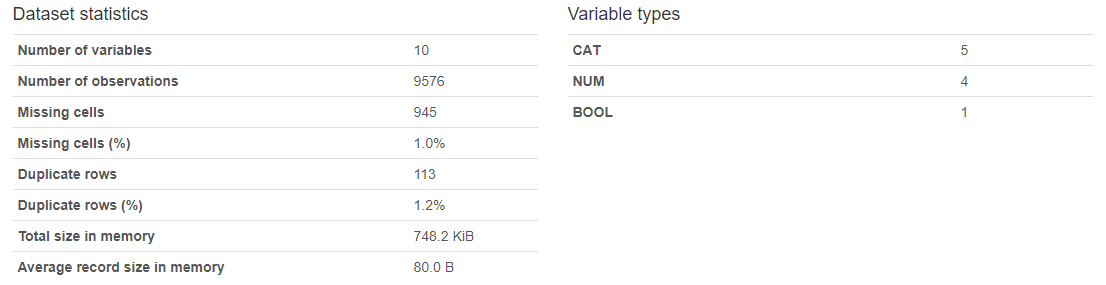


# <div style="text-align:center;background: -webkit-linear-gradient(#fff, #888);-webkit-background-clip: text;-webkit-text-fill-color: transparent;"> Data Processing </div>


In [8]:
# lets Drop the duplicate Value

carsales_df.drop_duplicates(inplace=True)
carsales_df.shape

(9463, 10)

<AxesSubplot:ylabel='Frequency'>

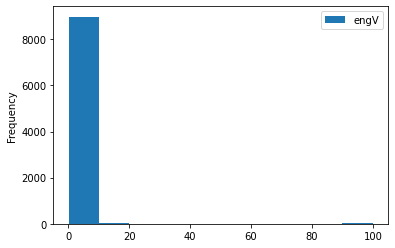

In [9]:
pd.DataFrame(carsales_df['engV']).plot.hist()

# Fixing *engV* missing / erroneous values

In [10]:
'''
Function that removes the ourlier entries of engV and returns dataframe
'''
def exclude_outliers_for_engV():
    return pd.DataFrame(carsales_df[(carsales_df.engV > 0.5) & (carsales_df.engV < 25)])



'''
Function that computes the mean value of engV based on make and model 
'''
def compute_engV_mean(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return round(r.mean(),2)
    else:
        engV_df = exclude_outliers_for_engV()
        engV_make = engV_df[engV_df.car == car_make].engV
        if engV_make.count() > 0:
            return round(engV_make.mean(),2)
        else:
            return round(engV_df.engV.mean(),2)
        
'''
Create a staging "engV mean" dataframe for  all combinations of make and model
'''
engV_mean = carsales_df.groupby(['car','model']).engV.apply(compute_engV_mean).reset_index()
engV_mean.rename(columns={'engV':'engV_avg'}, inplace=True)
engV_mean.head(10)

,car,model,engV_avg
0,Acura,MDX,3.62
1,Acura,RL,3.50
2,Acura,TL,3.20
3,Acura,TLX,2.40
4,Acura,ZDX,3.70
5,Alfa Romeo,147,1.60
6,Alfa Romeo,156,1.85
7,Alfa Romeo,159,2.20
8,Alfa Romeo,33,1.70
9,Alfa Romeo,75,1.60


In [11]:
'''
Function that return engV value for missing records
'''
def get_missing_engV(r):
    if pd.isnull(r.engV):
        return engV_mean[(engV_mean.car == r.car) & (engV_mean.model == r.model)].engV_avg.values[0]
    else:
        return r.engV
    

'''
Fix the missing engV values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

carsales_df.engV = carsales_df.apply(get_missing_engV, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

--------------Before fix-----------------
(434, 10)
--------------After fix -----------------
(0, 10)


# Fixing *price* missing / erroneous values

In [12]:
'''
Function that computes the median value of price based on make and model 
'''
def compute_price_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        price_make = carsales_df[carsales_df.car == car_make].price
        if price_make.median() > 0:
            return price_make.median()
        else:
            return carsales_df.price.median()

        
'''
Create a staging "Price median" dataframe for  all combinations of make and model
'''
price_median = carsales_df.groupby(['car','model']).price.apply(compute_price_median).reset_index()
price_median.rename(columns={'price':'price_median'}, inplace=True)
price_median.head(10)

,car,model,price_median
0,Acura,MDX,17200.0
1,Acura,RL,13950.0
2,Acura,TL,8699.0
3,Acura,TLX,38200.0
4,Acura,ZDX,30999.0
5,Alfa Romeo,147,5900.0
6,Alfa Romeo,156,2325.0
7,Alfa Romeo,159,12050.0
8,Alfa Romeo,33,1800.0
9,Alfa Romeo,75,2300.0


In [13]:
'''
Function that return price value for missing records
'''
def get_missing_price(r):
    if r.price == 0:
        return price_median[(price_median.car == r.car) & (price_median.model == r.model)].price_median.values[0]
    else:
        return r.price
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.price == 0].shape)

carsales_df.price = carsales_df.apply(get_missing_price, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.price == 0].shape)

--------------Before fix-----------------
(240, 10)
--------------After fix -----------------
(0, 10)


# Fixing *mileage* missing / erroneous values

In [14]:
'''
Function that computes the median value of mileage based on make and model 
'''
def compute_mileage_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        mileage_make = carsales_df[carsales_df.car == car_make].mileage
        if mileage_make.median() > 0:
            return mileage_make.median()
        else:
            return carsales_df.mileage.median()
        

        '''
Create a staging "mileage median" dataframe for  all combinations of make and model
'''
mileage_median = carsales_df.groupby(['car','model']).mileage.apply(compute_mileage_median).reset_index()
mileage_median.rename(columns={'mileage':'mileage_median'}, inplace=True)
mileage_median.head(10)

,car,model,mileage_median
0,Acura,MDX,85.0
1,Acura,RL,138.0
2,Acura,TL,145.0
3,Acura,TLX,4.0
4,Acura,ZDX,32.0
5,Alfa Romeo,147,199.0
6,Alfa Romeo,156,162.0
7,Alfa Romeo,159,120.5
8,Alfa Romeo,33,185.0
9,Alfa Romeo,75,122.0


In [15]:
'''
Function that return mileage value for missing records
'''
def get_missing_mileage(r):
    if r.mileage == 0:
        return mileage_median[(mileage_median.car == r.car) & (mileage_median.model == r.model)].mileage_median.values[0]
    else:
        return r.mileage
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

carsales_df.mileage = carsales_df.apply(get_missing_mileage, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

--------------Before fix-----------------
(310, 10)
--------------After fix -----------------
(0, 10)


# Fixing *drive* missing / erroneous values

In [16]:
'''
Function that removes the null entries of drive and returns dataframe
'''
def get_clensed_data_for_drive():
    return pd.DataFrame(carsales_df[carsales_df.drive.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_drive(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        drive_df = get_clensed_data_for_drive()
        drive_make = drive_df[drive_df.car == car_make].drive
        if drive_make.count() > 0:
            return drive_make.mode()
        else:
            return drive_df.drive.mode()
        
        
'''
Create a staging "drive mode" dataframe for  all combinations of make and model
'''
drive_mode = carsales_df.groupby(['car','model']).drive.apply(compute_drive).reset_index()
drive_mode.rename(columns={'drive':'drive_mode'}, inplace=True)
drive_mode.drop('level_2', axis=1)

,car,model,drive_mode
0,Acura,MDX,full
1,Acura,RL,full
2,Acura,TL,front
3,Acura,TLX,front
4,Acura,ZDX,full
...,...,...,...
914,ZX,LandMark,full
915,ËUAZ,1301,full
916,ËUAZ,1302,full
917,ËUAZ,969 Âîëûíü,full


In [17]:
'''
Function that return drive value for missing records
'''
def get_missing_drive(r):
    if pd.isnull(r.drive):
        return drive_mode[(drive_mode.car == r.car) & (drive_mode.model == r.model)].drive_mode.values[0]
    else:
        return r.drive
    
'''
Fix the missing drive values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

carsales_df.drive = carsales_df.apply(get_missing_drive, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

--------------Before fix-----------------
(510, 10)
--------------After fix -----------------
(0, 10)


# Fixing *engType* missing / erroneous values

In [18]:
'''
Function that removes the null entries of engType and returns dataframe
'''
def get_clensed_data_for_engType():
    return pd.DataFrame(carsales_df[carsales_df.engType.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_engType(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        engType_df = get_clensed_data_for_engType()
        engType_make = engType_df[engType_df.car == car_make].engType
        if engType_make.count() > 0:
            return engType_make.mode()
        else:
            return engType_df.engType.mode()
        
        
'''
Create a staging "engType mode" dataframe for  all combinations of make and model
'''
engType_mode = carsales_df.groupby(['car','model']).engType.apply(compute_engType).reset_index()
engType_mode.rename(columns={'engType':'engType_mode'}, inplace=True)
engType_mode.drop('level_2', axis=1)

,car,model,engType_mode
0,Acura,MDX,Petrol
1,Acura,RL,Gas
2,Acura,TL,Gas
3,Acura,TLX,Petrol
4,Acura,ZDX,Other
...,...,...,...
984,ZX,LandMark,Petrol
985,ËUAZ,1301,Petrol
986,ËUAZ,1302,Gas
987,ËUAZ,969 Âîëûíü,Petrol


In [19]:
'''
Function that return drive value for missing records
'''
def get_missing_engType(r):
    if pd.isnull(r.engType):
        return engType_mode[(engType_mode.car == r.car) & (engType_mode.model == r.model)].engType_mode.values[0]
    else:
        return r.engType
    
'''
Fix the missing engType values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

carsales_df.engType = carsales_df.apply(get_missing_engType, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

--------------Before fix-----------------
(0, 10)
--------------After fix -----------------
(0, 10)


In [20]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Post_Processing.html")